In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
%matplotlib nbagg

/home/brayan/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#!pip install numpy --upgrade

In [3]:
#r = [x1, y1, z1, vx1, vx2, vx3, x2, y2, z2, vx2, vy2, vz2,...] 
def n_body_diff_eqs(t, r, ms, G=1):
    #Number of bodies. For each body there must be 6 ecuations,
    #3 for the position (x, y, z) and 3 for the velocity (vx, vy, vz).
    n = 6
    N = int(len(r)/n)
    
    ecs = np.zeros(len(r))
    
    for i in range(N):
        dvdt_i = [0, 0, 0]
        
        for j in range(N):
            if i != j:
                d = np.sqrt((r[6*j+0]-r[6*i+0])**2 +
                            (r[6*j+1]-r[6*i+1])**2 +
                            (r[6*j+2]-r[6*i+2])**2 )
        
                for k in range(3):
                    dvdt_i[k] += G*ms[j]*( r[6*j+k] - r[6*i+k] ) / d**3
                 
        for l in range(3):
            ecs[6*i + l] = r[6*i + 3 + l]
            ecs[6*i + 3 + l] = dvdt_i[l] 
            
    return ecs


def plot_n_body_sol(sol, labels=False, plot_init=True, figsize=(9,9)):
    N = int(sol.shape[1]/6)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection="3d")
    font_label = {
            'family': 'serif',
            'weight': 'normal',
            'size': 8}
    
    font_label2 = {
            'family': 'serif',
            'weight': 'normal',
            'size': 10}
    
    if labels.any:
        for i in range(N):
            ax.plot(sol.T[6*i+0], sol.T[6*i+1], sol.T[6*i+2])
            ax.scatter(sol.T[6*i+0][0], sol.T[6*i+1][0], sol.T[6*i+2][0], "o", label=labels[i])
        
        plt.legend(loc="lower center", ncol=len(labels),
                   fancybox=True, shadow=True,
                   mode="expand",prop=font_label)
    else:
        for i in range(N):
            ax.plot(sol.T[6*i+0], sol.T[6*i+1], sol.T[6*i+2])
            ax.scatter(sol.T[6*i+0][0], sol.T[6*i+1][0], sol.T[6*i+2][0], "o")
    
    ax.set_xlabel("X [AU]", fontdict=font_label2)
    ax.set_ylabel("Y [AU]", fontdict=font_label2)
    ax.set_zlabel("Z [AU]", fontdict=font_label2)
    
    ax.set_zlim(ax.get_xlim())
        
    plt.tight_layout()

# N-body simulation for the Solar System

In [4]:
#Canonical units
m  = 1
km = 1000*m
kg = 1
s  = 1
G  = 6.67408e-11*m**3/kg/s**2

ul = 1.496e11*m
um = 1.9891e30*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1

In [5]:
#Load the initial conditions for the Solar System. (https://ssd.jpl.nasa.gov/horizons/app.html#/)
data = pd.read_csv("./initial_conditions_solar_system.csv")
data.columns = data.columns.str.strip()

#Converting the units from km, kg and sec to ul, um and ut
data[["X", "Y", "Z"]] = data[["X", "Y", "Z"]]*km/ul
data[["VX", "VY", "VZ"]] = data[["VX", "VY", "VZ"]]*km*ut/ul
data[["Mass"]] = data[["Mass"]]/um

#visualize data
data

,Body,Mass,JDTDB,Calendar Date (TDB),X,Y,Z,VX,VY,VZ
0,Sun,1.000000e+00,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.008663,-0.001562,0.000215,0.000176,-0.000481,3.862460e-08
1,Mercury,1.660148e-07,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.339949,0.129989,0.041352,-0.940673,-1.450777,-3.221998e-02
2,Venus,2.447589e-06,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.023965,-0.728248,-0.008879,1.167661,-0.029604,-6.776667e-02
3,Earth,3.003167e-06,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,0.324111,-0.962164,0.000263,0.929066,0.322754,-5.768790e-05
4,Mars,3.226836e-07,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-1.657854,0.154525,0.043940,-0.046112,-0.740797,-1.438007e-02
5,Jupiter,9.545020e-04,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,4.295264,2.460586,-0.106305,-0.222914,0.401238,3.321729e-03
6,Saturn,2.857875e-04,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,8.630429,-4.589742,-0.263813,0.134168,0.285672,-1.031256e-02
7,Uranus,4.364788e-05,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,12.791430,14.894383,-0.110397,-0.175103,0.138290,2.778441e-03
8,Neptune,5.148057e-05,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,29.800637,-2.338763,-0.638623,0.013087,0.182988,-4.077958e-03
9,Pluto,7.395304e-09,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,16.713506,-30.486667,-1.572293,0.164311,0.047213,-5.315728e-02


In [6]:
#Building the state vector for the bodies in the Solar System (not includding Pluto)
SV_solSystem = list(data.values[:,4:10][0:9].flatten())
ms_solSystem = list(data["Mass"].values[0:9])

#To see the full trayectory of every planet we solve the n-body problem
#from zero ut to the orbital period (in ut's) of the outter planet, here
#Neptune, its orbital period is 165 years.
t_max = 165*365*24*3600/ut
ts_solSystem = np.linspace(0,t_max,10000)

In [7]:
#solving the n-body problem for the Solar System
sol_solSystem = odeint(n_body_diff_eqs, y0=SV_solSystem, t=ts_solSystem, args=(ms_solSystem,), tfirst=True)

<IPython.core.display.Javascript object>


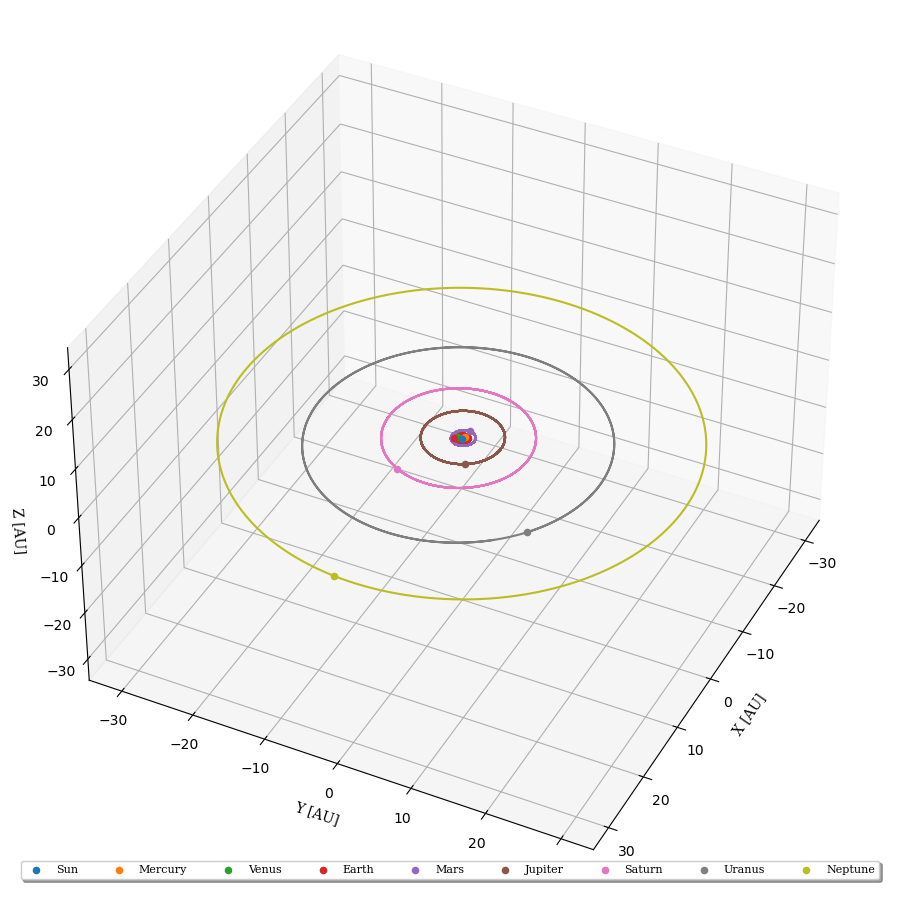

In [8]:
plot_n_body_sol(sol=sol_solSystem, labels=data.Body.values)